# Data Visualisation
This Jupyter Notebook contains code that visualises the data used in the thesis. First the networks are drawn then the raw and processed data, and finally the results are visualised

In [4]:
# Required packages (check which are required)
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import community
from shapely.geometry import Polygon

import random
import math

import cmocean as cmo


%matplotlib inline

In [5]:
# Read the data from data_processing.ipynb
# Calibration Data
sa_calibration_data = pd.read_csv('../Data_Labour/calibration_data.csv', sep = ',', index_col = 0)

# Network Data
absolute_workers = pd.read_csv('../Data_Labour/Occupation_transitions.csv', sep = ',', index_col = 0)
frey_osborne_translated = pd.read_csv('../Data_Labour/occupation_shock.csv', sep = ',', index_col = 'ssyk3')
employment_SSYK = pd.read_csv('../Data_Labour/occupational_employment.csv', sep = ',')

# Occupational Mobility Network
G = nx.read_graphml('../Data_Labour/Occ_mob_sweden.graphml')

# Occupational Mobility Network

In [105]:
# This sets up the visualization of the network
## The size of the nodes is proportional to the amount of workers who stayed in their proffesion between 2016 and 2017

def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    Used here to adjust the size of the nodes
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    return A/np.sum(A)

# Create the graph G from the adjeceny matrix
G = nx.read_graphml('../Data_Labour/Occ_mob_sweden.graphml')

# List of all the occupation codes
occupations = list(G.nodes)

# Dictionaries holding the first and second levels of the SSYK code respectively
first_level = {name:name[0] for name in occupations}
second_level = {name:name[0:1] for name in occupations}

# The amount of workers who stayed in their proffession
remain_workers = np.diag(absolute_workers)

# Make it into a dict 
remain_dict = dict(zip(list(G.nodes), remain_workers))

# Calculate the size of each node
ns = softmax(0.7*np.log2(10000+np.array(list(remain_dict.values()))))*15000

# Give the network the attributes used for visualisation
nx.set_node_attributes(G, first_level, 'SSYK1')
nx.set_node_attributes(G, second_level, 'SSYK2')
nx.set_node_attributes(G, remain_dict, 'remained_workers')

# Ten colors used for visualisation
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e", "#c36a7c"]

# Get all the unique first level codes
vals = list(set(val for val in first_level.values()))

# Make a dict that stores the color each node should get based on their first level
col_dict = {}
for i in range(len(vals)):
    col_dict[vals[i]] = cols[i]

# Make a list that contains the color of every node
node_col_list = [col_dict[val] for val in first_level.values()]
edge_col_list = [col_dict[val[0]] for val,_ in G.edges()]

# Make a list that contains the weight for each link
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = softmax(0.7*np.log2(1000+np.array(weights)))*1500


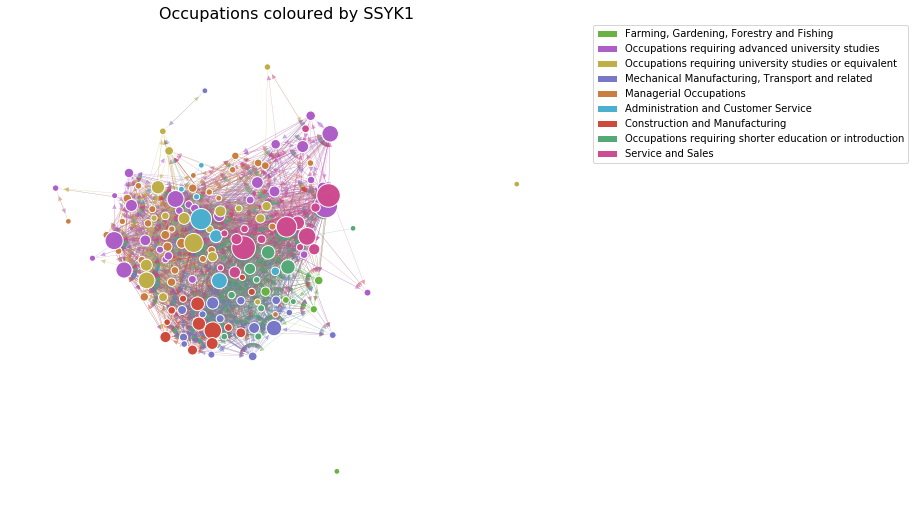

In [8]:
# This section visualises the network where nodes are colored by their first level code and the size correspond to the number of workers 
# who stayed in their proffession


fig, ax = plt.subplots(1,1,figsize=(10,9))

legend_elements = []

occ_dict = {'1': 'Chefsyrken', '2': 'Yrken med krav på fördjupad högskolekompetens', '3':'Yrken med krav på högskolekompetens eller motsvarande', '4': 'Yrken inom administration och kundtjänst', '5':'Service-, omsorgs- och försäljningsyrken', '6': 'Yrken inom lantbruk, trädgård, skogsbruk och fiske', '7':'Yrken inom byggverksamhet och tillverkning', '8': 'Yrken inom maskinell tillverkning och transport m.m.', '9':'Yrken med krav på kortare utbildning eller introduktion'}

en_occ_dict = {'1': 'Managerial Occupations', '2': 'Occupations requiring advanced university studies', '3':'Occupations requiring university studies or equivalent', '4': 'Administration and Customer Service', '5':'Service and Sales', '6': 'Farming, Gardening, Forestry and Fishing', '7':'Construction and Manufacturing', '8': 'Mechanical Manufacturing, Transport and related', '9':'Occupations requiring shorter education or introduction'}

for level, col in col_dict.items():
    legend_elements.append(Patch(facecolor = col, edgecolor='w', label=en_occ_dict[level]))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, with_labels = True, node_color=node_col_list, node_size = ns, alpha=0.99, edgecolors='w', ax = ax)

nx.draw_networkx_edges(G, pos, edge_color=edge_col_list, width=weights, alpha=0.5, ax=ax)

ax.set_axis_off()

ax.set_title("Occupations coloured by SSYK1", fontsize=16)


# Create the figure

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='lower center', borderaxespad=0.)

plt.savefig('../Graphs/Occ_mob_SSYK.pdf', dpi=425, bbox_inches='tight')
plt.show()

# Two occupations only have a self-loop

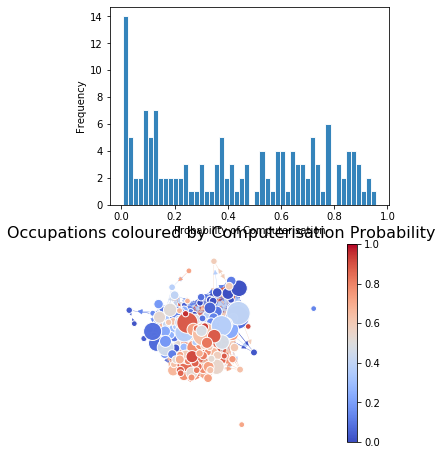

In [19]:
# Visualisation of Frey and Osborne data
# This section visualises the network where nodes are colored by their first level code and the size correspond to the number of workers 
# who stayed in their proffession
fig, axs = plt.subplots(2,1,figsize=(5,8))


fo_dict = {str(key):val for key, val in frey_osborne_translated.to_dict()['Computerisation Probability'].items()}

fo_vals = list(fo_dict.values())

axs[0].hist(fo_vals, bins = 50, ec = 'white', alpha = 0.9)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Probability of Computerisation')


node_colors = [plt.cm.coolwarm(fo_dict[occ]) for occ in G.nodes]
edge_colors = [plt.cm.coolwarm(fo_dict[occ]) for occ,_ in G.edges]

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(0,1))
sm._A = []
plt.colorbar(sm)

nx.draw_networkx_nodes(G, pos, with_labels = True, node_color=node_colors, node_size = ns, alpha=0.99, edgecolors='w', ax = axs[1])

nx.draw_networkx_edges(G, pos, edge_color= edge_colors, width=weights, alpha=0.5, ax=axs[1])

axs[1].set_axis_off()

axs[1].set_title("Occupations coloured by Computerisation Probability", fontsize=16)

plt.savefig('../Graphs/Occ_mob_CP.pdf', dpi=425, bbox_inches='tight')
plt.show()

In [64]:
sa_calibration_data

Unnamed: 0    date  u_sa  u_trend  sa_vac  na_vac     e_sa  e_trend  \
0            0  2004Q1   7.3     7.28   35671   36292  4333700  4338350   
1            1  2004Q2   7.4     7.40   36284   41036  4327900  4339740   
2            2  2004Q3   7.4     7.40   40067   36715  4337100  4337880   
3            3  2004Q4   7.4     7.40   38144   36040  4331200  4334150   
4            4  2005Q1   7.3     7.51   36821   37510  4337700  4332290   
..         ...     ...   ...      ...     ...     ...      ...      ...   
59          59  2018Q4   6.4     6.46  120861  103726  5114500  5108280   
60          60  2019Q1   6.8     6.62  122679  143769  5115800  5113630   
61          61  2019Q2   6.5     6.77  122679  136739  5121300  5121390   
62          62  2019Q3   6.9     6.85  116940   99187  5134000  5133770   
63          63  2019Q4   6.8     6.86  114620   96569  5152500  5150320   

    recession  sa_vac_rate  
0           0     0.815520  
1           0     0.829155  
2           0     0.915201  
3           0     0.872402  
4           1     0.842757  
..        ...          ...  
59          0     2.311297  
60          0     2.342853  
61          0     2.339386  
62          0     2.227127  
63          0     2.177043  

[64 rows x 10 columns]

# Beveridge Curve

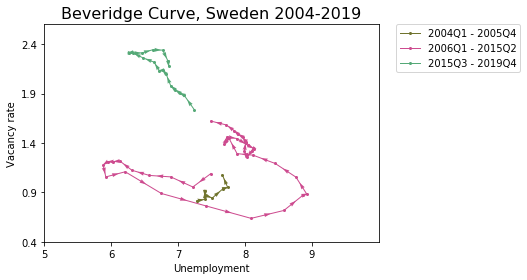

In [63]:
sa_calibration_data = pd.read_csv('../Data_Labour/calibration_data.csv')

plot_ls = []
plot_dict = {'start': '', 'end': '', 'u': [], 'vac': []}

prev_status = sa_calibration_data['recession'].iloc[0]
plot_dict['start'] = sa_calibration_data['date'].iloc[0]
status_change = 0
for i in range(len(sa_calibration_data)):
    status = sa_calibration_data['recession'].iloc[i]
    if status == prev_status:
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
    else:
        status_change += 1
        if status_change == 3:
            plot_dict['end'] = sa_calibration_data['date'].iloc[i-1]
            plot_ls.append(plot_dict)
            plot_dict = {'start': sa_calibration_data['date'].iloc[i], 'end': '', 'u': [sa_calibration_data['u_trend'].iloc[i]], 'vac': [sa_calibration_data['sa_vac_rate'].iloc[i]]}
            status_change = 0
        else:
            plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
            plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
    prev_status = status

plot_dict['end'] = sa_calibration_data['date'].iloc[-1]
plot_ls.append(plot_dict)


x = sa_calibration_data['u_trend'].values
y = sa_calibration_data['sa_vac_rate'].values



fig, ax = plt.subplots()
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e"]

legend_elements = []

for data in plot_ls:
    col = cols.pop()
    plt.plot(data['u'], data['vac'], color = col, ls = '-', marker = 'o', linewidth = 1, markersize = 2, label = data['start']+' - '+data['end'])
    x = data['u']
    y = data['vac']
    u = np.diff(x)
    v = np.diff(y)
    pos_x = x[:-1] + u/2
    pos_y = y[:-1] + v/2
    norm = np.sqrt(u**2+v**2) 
    ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = col)
    #legend_elements.append(Patch(facecolor = col, edgecolor='w', label=data['start']+' - '+data['end']))
    # plt.annotate(data['start'], # this is the text
    #              (data['u'][0],data['vac'][0]), # this is the point to label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,-10), # distance from text to points (x,y)
    #              ha='center')
    # plt.annotate(data['end'], # this is the text
    #              (data['u'][-1],data['vac'][-1]), # this is the point to label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,15), # distance from text to points (x,y)
    #              ha='center')



# ax.axis('equal')
ax_bounds = [5, 10, 0.4, 2.6]
ax.axis(ax_bounds)
ax.xaxis.set_ticks(np.arange(ax_bounds[0], ax_bounds[1], 1))
ax.yaxis.set_ticks(np.arange(ax_bounds[2], ax_bounds[3], 0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title("Beveridge Curve, Sweden 2004-2019", fontsize=16)
ax.set_xlabel('Unemployment')
ax.set_ylabel('Vacancy rate')

# plt.savefig('../Graphs/Beveridge_curve.pdf', dpi=425, bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Vacancy rate')

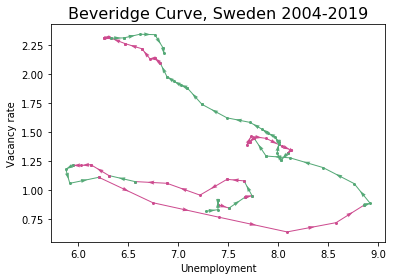

In [15]:
sa_calibration_data = pd.read_csv('../Data_Labour/calibration_data.csv')

plot_ls = []
plot_dict = {'u': [], 'vac': []}
status = False

for i in range(len(sa_calibration_data)):
    current_status = sa_calibration_data['gap_change'].iloc[i] >= 0
    if current_status == status:
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
        plot_dict['gap_change'] = status
    else:
        plot_ls.append(plot_dict)
        plot_dict = {'u': [sa_calibration_data['u_trend'].iloc[i-1]], 
                    'vac': [sa_calibration_data['sa_vac_rate'].iloc[i-1]]}
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
        plot_dict['gap_change'] = status
        status = current_status

plot_ls.append(plot_dict)


fig, ax = plt.subplots()
cols = [ "#55a977", "#cd4b8f"]
legend_elements = []

for data in plot_ls:
    if data['gap_change'] == False:
        plt.plot(data['u'], data['vac'], color = cols[0], ls = '-', marker = 'o', linewidth = 1, markersize = 2)
        x = data['u']
        y = data['vac']
        u = np.diff(x)
        v = np.diff(y)
        pos_x = x[:-1] + u/2
        pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = cols[0])
    else:
        plt.plot(data['u'], data['vac'], color = cols[1], ls = '-', marker = 'o', linewidth = 1, markersize = 2)
        x = data['u']
        y = data['vac']
        u = np.diff(x)
        v = np.diff(y)
        pos_x = x[:-1] + u/2
        pos_y = y[:-1] + v/2
        norm = np.sqrt(u**2+v**2) 
        ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = cols[1])
    


# ax_bounds = [5, 10, 0.4, 2.6]
# ax.axis(ax_bounds)
# ax.xaxis.set_ticks(np.arange(ax_bounds[0], ax_bounds[1], 1))
# ax.yaxis.set_ticks(np.arange(ax_bounds[2], ax_bounds[3], 0.5))
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title("Beveridge Curve, Sweden 2004-2019", fontsize=16)
ax.set_xlabel('Unemployment')
ax.set_ylabel('Vacancy rate')

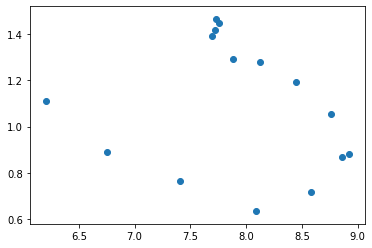

In [18]:


plt.scatter()

date  u_sa  u_trend  sa_vac  na_vac     e_sa  e_trend  recession  \
date                                                                         
2008Q1  2008Q1   5.9     5.88   54803   57170  4595100  4596100          0   
2008Q2  2008Q2   6.0     5.92   49182   55017  4606200  4605710          0   
2008Q3  2008Q3   6.2     6.21   51548   47653  4594600  4598620          1   
2008Q4  2008Q4   6.7     6.75   41023   35828  4579600  4573550          1   
2009Q1  2009Q1   7.4     7.41   34968   37991  4541300  4541460          1   
2009Q2  2009Q2   8.4     8.09   28926   36107  4504800  4510660          1   
2009Q3  2009Q3   8.6     8.58   32441   27605  4469200  4491080          1   
2009Q4  2009Q4   8.8     8.86   39306   32643  4485200  4484220          1   
2010Q1  2010Q1   8.9     8.92   40039   44142  4485800  4490160          1   
2010Q2  2010Q2   8.7     8.76   48033   56975  4512200  4508000          1   
2010Q3  2010Q3   8.5     8.45   54737   48501  4534500  4536040          1   
2010Q4  2010Q4   8.1     8.12   59080   50496  4562000  4569920          1   
2011Q1  2011Q1   7.9     7.88   60221   66247  4605900  4600680          1   
2011Q2  2011Q2   7.8     7.76   67848   78365  4623700  4621210          1   
2011Q3  2011Q3   7.6     7.72   66584   58345  4630200  4632610          1   
2011Q4  2011Q4   7.8     7.69   65475   55413  4642100  4641840          1   
2012Q1  2012Q1   7.7     7.73   68980   77402  4642600  4649990          1   
2012Q2  2012Q2   7.9     7.88   68231   79537  4657700  4655000          1   
2012Q3  2012Q3   8.1     8.04   65027   54729  4657200  4659690          1   
2012Q4  2012Q4   8.2     8.13   63572   52709  4668900  4667910          1   
2013Q1  2013Q1   8.1     8.10   62609   73501  4681000  4681060          1   
2013Q2  2013Q2   8.0     8.03   59779   71011  4696100  4697550          1   
2013Q3  2013Q3   8.0     7.99   62764   50665  4708900  4711830          1   
2013Q4  2013Q4   8.0     8.01   67576   56511  4732000  4722980          1   
2014Q1  2014Q1   8.1     8.01   67230   80131  4731100  4738920          1   
2014Q2  2014Q2   8.0     7.97   70494   81590  4758500  4763010          1   
2014Q3  2014Q3   7.8     7.90   72324   58693  4802800  4787510          1   
2014Q4  2014Q4   7.8     7.84   74287   62805  4797000  4802010          1   
2015Q1  2015Q1   7.7     7.72   77348   92324  4810600  4810740          1   

        gap_change  sa_vac_rate  year     workforce  
date                                                 
2008Q1   -0.370928     1.178330  2008  4.883234e+06  
2008Q2   -0.432826     1.056566  2008  4.895525e+06  
2008Q3   -1.041481     1.108519  2008  4.903103e+06  
2008Q4  110.485940     0.888988  2008  4.904611e+06  
2009Q1    0.260191     0.764089  2009  4.904914e+06  
2009Q2    0.092228     0.637195  2009  4.907692e+06  
2009Q3    0.096069     0.717163  2009  4.912579e+06  
2009Q4    0.033051     0.868924  2009  4.920145e+06  
2010Q1   -0.424312     0.883824  2010  4.929908e+06  
2010Q2   -0.314684     1.054272  2010  4.940815e+06  
2010Q3   -0.185756     1.192325  2010  4.954713e+06  
2010Q4   -0.491729     1.276302  2010  4.973792e+06  
2011Q1   -0.271232     1.292046  2011  4.994225e+06  
2011Q2    0.365343     1.446943  2011  5.009985e+06  
2011Q3   -0.636236     1.416924  2011  5.020167e+06  
2011Q4    4.061598     1.390920  2011  5.028534e+06  
2012Q1    0.085900     1.461760  2012  5.039547e+06  
2012Q2    0.126967     1.444583  2012  5.053191e+06  
2012Q3    0.278720     1.376315  2012  5.067084e+06  
2012Q4    0.279774     1.343596  2012  5.080995e+06  
2013Q1   -0.179686     1.319843  2013  5.093645e+06  
2013Q2    0.153972     1.256566  2013  5.107698e+06  
2013Q3   -0.019325     1.314541  2013  5.120998e+06  
2013Q4   -0.145429     1.410609  2013  5.134232e+06  
2014Q1   -0.111333     1.398833  2014  5.151560e+06  
2014Q2   -0.179976     1.458445  2014  5.175497e+06  
2014Q3   -0.101855     1.488199  2014  5.198165e+06  
2014Q4   -0.185339     1.

# results

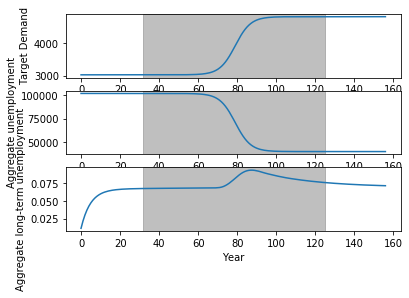

In [54]:
vac_data = pd.read_csv('../Data_Labour/vac_simulation.csv', sep = ',')
e_data = pd.read_csv('../Data_Labour/emp_simulation.csv', sep = ',')
u_data = pd.read_csv('../Data_Labour/unemp_simulation.csv', sep = ',')
td_data = pd.read_csv('../Data_Labour/td_simulation.csv', sep = ',')

# Pick example occupations

cols = ["#89b3da",
"#dd98a0"]

u_agg = u_data.sum(1)
e_agg = e_data.sum(1)
u_rel = pd.Series([u/(e_agg.iloc[i]+ u) for i,u in enumerate(u_agg)])

# Top should be demand curve for example occupations over time
# Bottom should be aggregated unemployment over time
# Long term unemployment

period = 10.25
shock_period = 30
timestep = 16.6

pre_steps = int(period*52/timestep) # Steps before the automation shock
shock_steps = int(shock_period*52/timestep) # Steps during the automation shock
post_steps = int(period*52/timestep) # Steps after the automation shock

data_list = [td_data['111'], td_data['432'], u_rel]

fig, axs = plt.subplots(4, 1)

for i, ax in enumerate(axs):
    data = data_list[i]
    ax.plot(data.index, data.values)
    ax.axvspan(pre_steps, pre_steps + shock_steps, alpha=0.5, color='grey')
    if i == 0:
        ax.set_ylabel('Target Demand')
    elif i == 2:
        ax.set_ylabel('Aggregate unemployment')
    elif i == 3:
        ax.set_ylabel('Aggregate long-term unemployment')
        ax.set_xlabel('Year') 

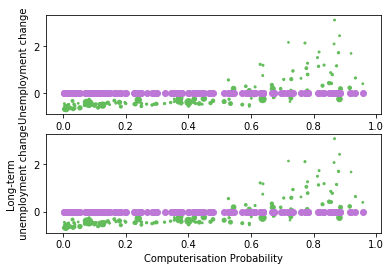

In [136]:
# Simulation data
e_data = pd.read_csv('../Data_Labour/emp_simulation.csv', sep = ',')
u_data = pd.read_csv('../Data_Labour/unemp_simulation.csv', sep = ',')
e_avg = e_data.mean(0)
u_avg = u_data.mean(0)

u_avg_rel = pd.DataFrame([u/(u+e_avg.iloc[i])*100/len(u_avg) for i, u in enumerate(u_avg)], index = u_avg.index, columns = ['u'])

e_avg.name = 'e'

u_avg_rel.index = u_avg_rel.index.astype(int)
e_avg.index = e_avg.index.astype(int)

# Computerisation probability
frey_osborne_translated.index.name = None

avg_data = frey_osborne_translated.merge(u_avg_rel, left_index = True, right_index = True)
avg_data = avg_data.merge(e_avg, left_index = True, right_index = True)

# Starting values
start = int(10.25*52/16.6)
e_start = e_data.iloc[start]
u_start = u_data.iloc[start]

avg_data['u_start'] =  [u/(u+e_start.iloc[i]) for i, u in enumerate(u_start)]

avg_data['u_change'] = (avg_data['u'] - avg_data['u_start'])/avg_data['u_start']

sizes = softmax(0.7*np.log2(10000+np.array(list(avg_data['e']))))*1500
avg_data['size'] = sizes
avg_data['u_c'] = 0

data_list = []
data_list.append(avg_data)
data_list.append(avg_data)


# Pick example occupations

cols = ["#62bc5a", "#bd77d7"]



# Unemployment against computerisation probability
# size of each point proportional to employment at given time
# Both complete network and occupational mobility network


fig, axs = plt.subplots(2, 1)

for i, ax in enumerate(axs):
    data = data_list[i]
    ax.scatter(data['Computerisation Probability'], data['u_change'], s = data['size'], c = cols[0])
    ax.scatter(data['Computerisation Probability'], data['u_c'], c = cols[1])
    if i == 0:
        ax.set_ylabel('Unemployment change')
    else:
        ax.set_ylabel('Long-term \n unemployment change')
        ax.set_xlabel('Computerisation Probability')

In [114]:
start = int(10.25*52/16.6)
e_data.iloc[start]

111     2801.0
112    20409.0
121    17065.0
122     8242.0
123    10117.0
        ...   
933     9307.0
941    73735.0
952      166.0
961     8332.0
962    37048.0
Name: 32, Length: 145, dtype: float64

In [137]:
avg_data

Computerisation Probability         u             e   u_start  u_change  \
111                     0.100500  0.011950   3150.611465  0.022339 -0.465057   
112                     0.087500  0.017674  25939.872611  0.035537 -0.502655   
121                     0.069000  0.019634  22073.133758  0.040430 -0.514370   
122                     0.323933  0.017431   8926.012739  0.031492 -0.446491   
123                     0.423125  0.018903  10177.585987  0.034084 -0.445408   
..                           ...       ...           ...       ...       ...   
933                     0.528000  0.040509   8644.643312  0.026057  0.554624   
941                     0.886250  0.058591  46580.203822  0.049390  0.186283   
952                     0.920000  0.152308    103.369427  0.056818  1.680613   
961                     0.629667  0.055033   7051.662420  0.024813  1.217930   
962                     0.828846  0.058757  25158.433121  0.044736  0.313411   

          size  u_c  
111   3.552612    0  
112   9.806072    0  
121   8.741203    0  
122   5.131261    0  
123   5.474055    0  
..         ...  ...  
933   5.054227    0  
941  15.507136    0  
952   2.722302    0  
961   4.618319    0  
962   9.590775    0  

[145 rows x 7 columns]

In [94]:
pd.DataFrame([u/(u+e_avg.iloc[i]) for i, u in enumerate(u_avg)], index = u_avg.index, columns = ['u'])

u
111  0.017327
112  0.025628
121  0.028469
122  0.025275
123  0.027409
..        ...
933  0.058738
941  0.084957
952  0.220846
961  0.079798
962  0.085197

[145 rows x 1 columns]

In [91]:
frey_osborne_translated

Computerisation Probability
111                     0.100500
112                     0.087500
121                     0.069000
122                     0.323933
123                     0.423125
..                           ...
933                     0.528000
941                     0.886250
952                     0.920000
961                     0.629667
962                     0.828846

[145 rows x 1 columns]

In [ ]:
f